## Madhavi Ghanta
## Exercise 6.2
## DSC 530
## 07/14/23¶

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [2]:
# Loading packages needed
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import pandas as pd

import brfss
import nsfg

import thinkstats2
import thinkplot

(Using data from the NSFG, make a scatter plot of birth weight versus mother’s age…)

In [3]:
# Data
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

ages = live.agepreg
weights = live.totalwgt_lb

Scatter plot of birth weight versus mother’s age

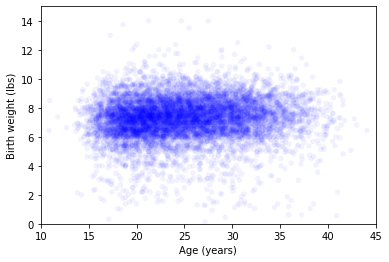

In [4]:
def ScatterPlot(ages, weights, alpha=1.0, s=20):

    thinkplot.Scatter(ages, weights, alpha=alpha)
    thinkplot.Config(xlabel='Age (years)',
                     ylabel='Birth weight (lbs)',
                     xlim=[10, 45],
                     ylim=[0, 15],
                     legend=False)
    
ScatterPlot(ages, weights, alpha=0.05, s=10)

Pearson’s and Spearman’s correlations

In [5]:
# Creating the covariance function
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [6]:
#  Creating the Pearson’s correlation function
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

In [7]:
#  Creating the Spearman correlation function
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

In [8]:
print('Pearson’s correlation', Corr(ages, weights))
print('Spearman correlation', SpearmanCorr(ages, weights))

Pearson’s correlation 0.0688339703541091
Spearman correlation 0.09461004109658226


Plot percentiles of birth weight versus mother’s age.

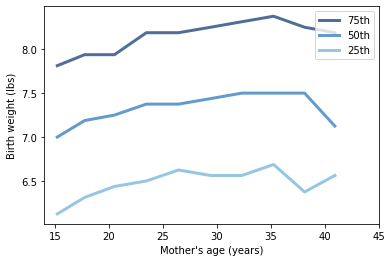

In [9]:
#  Creating the Percentiles function
def BinnedPercentiles(df):
    """Bin the data by age and plot percentiles of weight for each bin.

    df: DataFrame
    """
    bins = np.arange(10, 48, 3)
    indices = np.digitize(df.agepreg, bins)
    groups = df.groupby(indices)

    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]

    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ages, weights, label=label)

    thinkplot.Config(xlabel="Mother's age (years)",
                     ylabel='Birth weight (lbs)',
                     xlim=[14, 45], legend=True)

# Plot percentiles of birth weight versus mother’s age
BinnedPercentiles(live)

How would you characterize the relationship between these variables?

Based off the above anaylsis, we can conlcude that birth weight and mother’s age are not correlated. Both the Pearson’s and Spearman’s correlations fall under 0.1, meaning that their relationship is not strong enough for it to be of any signifiance. We can also conclude that the outliers influence the relationsip due to the difference between the Pearson’s and Spearman’s correlation coefficients (or that their relaionship is non-linear).

## 8-1
(In this chapter we used sample mean to estimate • and found that the sample mean yields lower MSE…)

Running experiments to see if and median are biased estimates of µ.

In [10]:
# Cerating a function to compute the mean error for a collection of estimates.
def MeanError(estimates, actual):
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

In [11]:
import random

# Creating the estimate function
def Estimate1(n=7, iters=100000):
    random.seed(10) # setting the seed so the random numbers are unchanged
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment One')
    print('Mean error for sample mean', MeanError(means, mu))
    print('Mean error for median', MeanError(medians, mu))
    
Estimate1()

Experiment One
Mean error for sample mean -0.00192335186034549
Mean error for median -0.0013015688016481787


Based on the above experiment with a sample mean error of -0.0019 and median mean error of -0.0013, we can conclude that median could be biased estimates of µ since the error is smaller. However, the difference is minimal and while this test yeilded a lower RMSE for the median, this won't always be the case. Using the median for calulacting the error is the preferred meathed since it does a better job in the presence of outliers or large errors.

Checking whether S^2 or S^2 (n-1) yields a lower MSE.

In [12]:
# Funcstion for calculating the RMSE (mean squared error of a sequence of estimates)
def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

In [13]:
# Function for biased and unbiased estimators of population variance.
def Estimate2(n=7, iters=100000):
    random.seed(10) # setting the seed so the random numbers are unchanged
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    estimates3 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        unbiased2 = np.var(xs, ddof=2)
        estimates1.append(biased)
        estimates2.append(unbiased)
        estimates3.append(unbiased2)

    print('Experiment Two')
    print('RMSE biased', RMSE(estimates1, sigma**2))
    print('RMSE unbiased', RMSE(estimates2, sigma**2))
    print('RMSE unbiased two degrees of freedom', RMSE(estimates3, sigma**2))
Estimate2()

Experiment Two
RMSE biased 0.5145790308398224
RMSE unbiased 0.5766562622157307
RMSE unbiased two degrees of freedom 0.7202096542581465


Based on the above experiment with a biased RMSE of 0.514 and an unbiased RSME of 0.576, we can conclude that the biased estimator of variance yields lower RMSE. Meaning that the RMSE increases as the degrees of freeddom increases.

## 8-2

(Suppose that you draw a sample size with n = 10 from an exponential distribution with …)

standard error 0.7947147609077992
confidence interval (1.2585483717148078, 3.8008242363700444)


0.7947147609077992

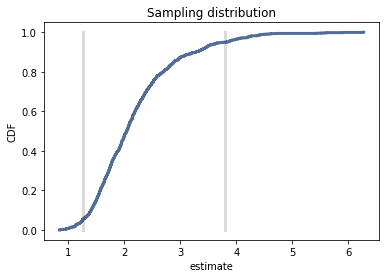

In [14]:
# Sampling distribution function
def SimulateSample(lam=2, n=10, iters=1000):
    def VertLine(x, y=1):
        thinkplot.Plot([x, x], [0, y], color='0.8', linewidth=3)

    estimates = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        lamhat = 1.0 / np.mean(xs)
        estimates.append(lamhat)

    stderr = RMSE(estimates, lam)
    print('standard error', stderr)

    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('confidence interval', ci)
    VertLine(ci[0])
    VertLine(ci[1])

    # plotting the CDF
    thinkplot.Cdf(cdf)
    thinkplot.Config(xlabel='estimate',
                     ylabel='CDF',
                     title='Sampling distribution')

    return stderr

SimulateSample()

Based off this experiment we can see as our sample size increases the standard error and the width of the confindence interval decreases.